## Семинар 9: "LSTM"

ФИО: Коновалов Михаил Анатольевич

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import MSELoss
from tqdm.notebook import tqdm
import math
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

Я добавить умную инициализацию весов lstm с учетом размера вектора скрытого состояния, как это сделано в pytorch реализации. Это сильно улучшило метрику на тестовом датасете.

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        std = 1 / math.sqrt(self.hidden_size)
        self.W_i = nn.Parameter(nn.init.uniform_(torch.Tensor(input_size, self.gate_size), -std, std))
        
        self.W_h = nn.Parameter(nn.init.uniform_(torch.Tensor(hidden_size, self.gate_size), -std, std))
        
        self.b = nn.Parameter(nn.init.uniform_(torch.Tensor(self.gate_size), -std, std))
#         self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
#         self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
#         self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden=None):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        if hidden:
            h, c = hidden
        else:
            h, c = torch.zeros(self.hidden_size), torch.zeros(self.hidden_size)
        bs = inputs.size(1)
        
        seq_length = inputs.size(0)
        out = torch.Tensor(seq_length, bs, self.hidden_size)
        
        for i, inp in enumerate(inputs):
            S = torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b
            S = S.view(bs, 4, self.hidden_size)
            i_1 = torch.sigmoid(S[:, 0, :])
            f_1 = torch.sigmoid(S[:, 1, :])
            g_1 = torch.tanh(S[:, 2, :])
            o_1 = torch.sigmoid(S[:, 3, :])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

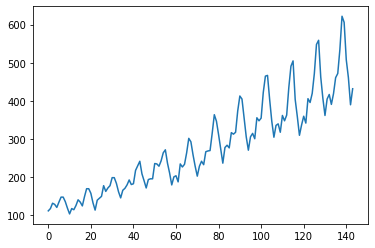

In [30]:
%matplotlib inline
dataset = pandas.read_csv('~/data/international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [31]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [32]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [33]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [48]:
# Пример подготовленных данных

LOOK_BACK = 25
LOOK_FORWARD = 1
trainX, trainY = create_dataset(train, LOOK_BACK, LOOK_FORWARD)
testX, testY = create_dataset(test, LOOK_BACK, LOOK_FORWARD)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [49]:
BATCH_SIZE = 10

train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

In [51]:
class Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, custom=False):
        super(Network, self).__init__()
        lstm = LSTM if custom else nn.LSTM
        self.lstm = lstm(input_size=input_size, hidden_size=hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, inputs):
        lstm_output, (h, c) = self.lstm(inputs)
        linear_output = self.linear(h)
        return linear_output

In [61]:
def train_test_evaluate(model):
    test_outputs = [item[0] for item in train[-LOOK_BACK:].tolist()]
    train_outputs = [item[0] for item in train[:LOOK_BACK].tolist()]
    
    with torch.no_grad():
        for _ in range(len(train) - LOOK_BACK):
            input_ = torch.Tensor(train_outputs[-LOOK_BACK:]).reshape(LOOK_BACK, 1, 1).float()
            train_outputs.append(float(model(input_)))

        for _ in range(len(test)):
            input_ = torch.Tensor(test_outputs[-LOOK_BACK:]).reshape(LOOK_BACK, 1, 1).float()
            test_outputs.append(float(model(input_)))
    
    return train_outputs, test_outputs


def train_test_eval_mse(train_outputs, test_outputs):
    train_mse = float(((torch.Tensor(train[LOOK_BACK:]).squeeze() - torch.Tensor(train_outputs[LOOK_BACK:])) ** 2).sum()) / len(train_outputs)
    test_mse = float(((torch.Tensor(test).squeeze() - torch.Tensor(test_outputs[LOOK_BACK:])) ** 2).sum()) / len(test_outputs)
    return train_mse, test_mse


def show_train_test_plots(train_outputs, test_outputs):
    fig = plt.figure(figsize=(20, 13))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    
    ax1.plot(train_outputs, c="red", label="Model train")
    ax1.plot(train[:, 0].tolist(), c="blue", label="Data train")
    
    ax2.plot(test_outputs, c="red", label="Model test")
    ax2.plot(train[-LOOK_BACK:, 0].tolist() + test[:, 0].tolist(), c="blue", label="Data test")
    
    ax1.legend()
    ax2.legend()

In [62]:
def mse(model, dataset):
    with torch.no_grad():
        X = dataset.tensors[0]
        outs = model(X.permute(2, 0, 1)).squeeze()
    return ((dataset.tensors[1][:, 0] - outs) ** 2).sum() / len(dataset)


def show_full_plots(model):
    fig = plt.figure(figsize=(18, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    
    with torch.no_grad():
        X_train = train_dataset.tensors[0]
        train_outs = model(X_train.permute(2, 0, 1))
        ax1.plot(train_dataset.tensors[1], c="red", label="Train data")
        ax1.plot(train_outs.detach().squeeze(), c="blue", label="Train model")
        ax1.legend()

        X_test = test_dataset.tensors[0]
        test_outs = model(X_test.permute(2, 0, 1))
        ax2.plot(test_dataset.tensors[1], c="red", label="Test data")
        ax2.plot(test_outs.detach().squeeze(), c="blue", label="Test model")
        ax2.legend()

In [95]:
def train_model(hidden_size, n_epochs=1000, lr=1e-3, custom=False):
    loss = nn.MSELoss()
    input_size = 1

    model = Network(input_size, hidden_size)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-5)

    for i in tqdm(range(n_epochs), total=n_epochs):
        loss_values = []
        for batch in train_dataloader:
            X = batch[0]
            y = batch[1]

            optimizer.zero_grad()
            output = model(X.permute(2, 0, 1))
            loss_value = loss(output.squeeze(), y.squeeze())
            loss_value.backward()
            optimizer.step()
        
        if (i + 1) % 100 == 0:
            train_mse = mse(model, train_dataset)
            test_mse = mse(model, test_dataset)
            train_eval_mse, test_eval_mse = train_test_eval_mse(*train_test_evaluate(model))
            print(f"[{i + 1}]\tTrain:\t{train_mse}\tTrain eval:\t{train_eval_mse}\n\tTest:\t{test_mse}\tTest eval:\t{test_eval_mse}\n")
            
    return model

In [96]:
model = train_model(32, n_epochs=500)

[100]	Train:	0.0037448660004884005	Train eval:	0.024064702292283375
	Test:	0.017547165974974632	Test eval:	0.012686343225714278

[200]	Train:	0.0017148402985185385	Train eval:	0.002566903829574585
	Test:	0.04602097347378731	Test eval:	0.023938987353076674

[300]	Train:	0.0008110813214443624	Train eval:	0.0012837037599335115
	Test:	0.011457068845629692	Test eval:	0.009498019741006093

[400]	Train:	0.0006859785644337535	Train eval:	0.0017512251312534015
	Test:	0.009776569902896881	Test eval:	0.04267701057538594

[500]	Train:	0.0006016072584316134	Train eval:	0.002032482996582985
	Test:	0.004123047925531864	Test eval:	0.004507151368546159




Первый ряд графиков - предсказание по каждым 25 точкам датасета 26-й точки. Второй ряд - восстановление по 25 начальным точкам оставшейся части датасета.

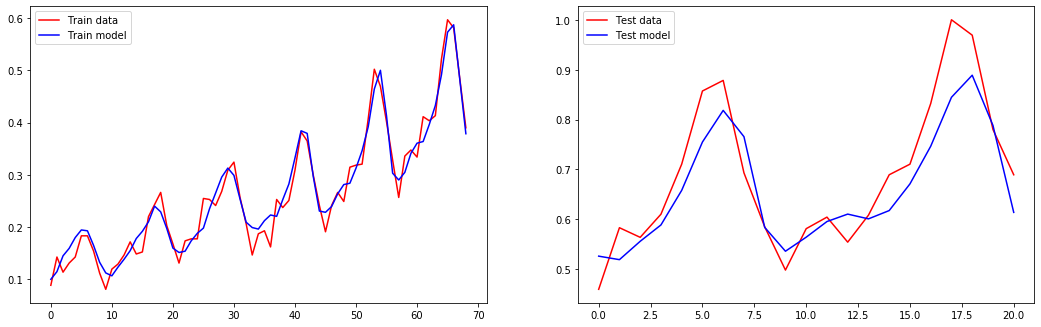

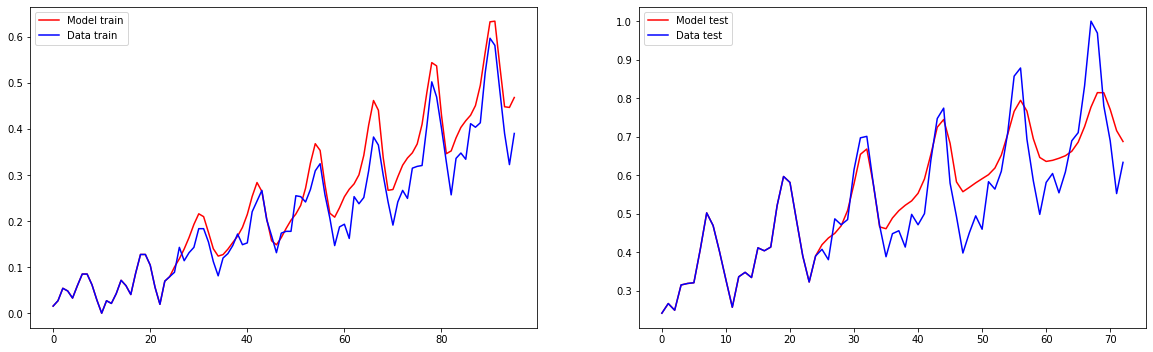

In [97]:
show_full_plots(model)
show_train_test_plots(*train_test_evaluate(model))

In [107]:
model = train_model(256, n_epochs=500)

[100]	Train:	0.0049890573136508465	Train eval:	0.007172921672463417
	Test:	0.05678113177418709	Test eval:	0.07011421412637789

[200]	Train:	0.0012842216528952122	Train eval:	0.003608475128809611
	Test:	0.008893641643226147	Test eval:	0.017996837015021337

[300]	Train:	0.0016032394487410784	Train eval:	0.002804000241061052
	Test:	0.13852040469646454	Test eval:	0.30474594847796715

[400]	Train:	0.0025158985517919064	Train eval:	0.03733722368876139
	Test:	0.05948489159345627	Test eval:	0.21679179309165642

[500]	Train:	0.0009459907305426896	Train eval:	0.004179800860583782
	Test:	0.007660115137696266	Test eval:	0.012885563177605197




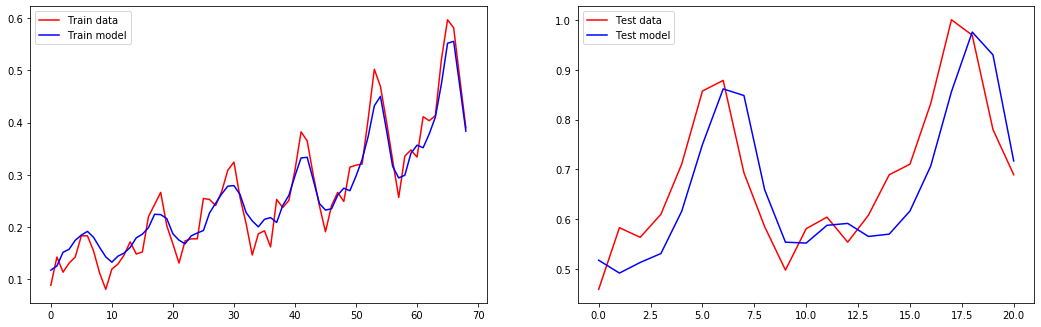

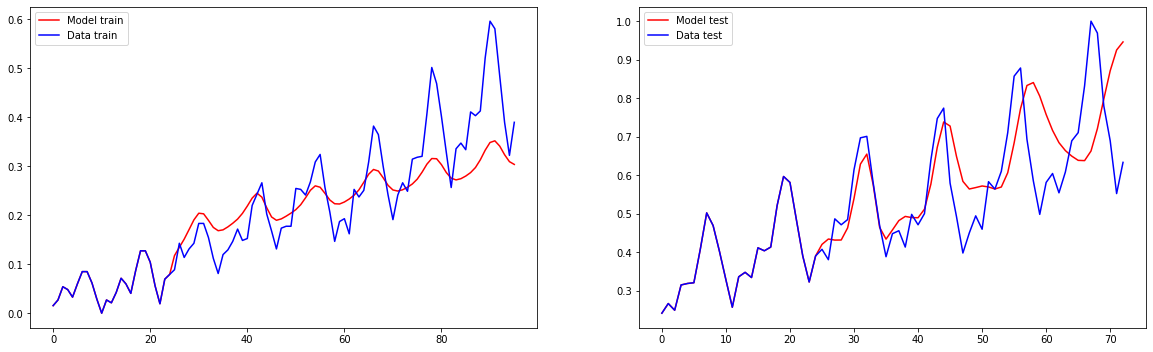

In [108]:
show_full_plots(model)
show_train_test_plots(*train_test_evaluate(model))

# Собственная реализация LSTM

In [114]:
model = train_model(32, n_epochs=500, custom=True)

[100]	Train:	0.0033376298379153013	Train eval:	0.011472590267658234
	Test:	0.023989569395780563	Test eval:	0.013337967330462311

[200]	Train:	0.0019297859398648143	Train eval:	0.002936706878244877
	Test:	0.04657316580414772	Test eval:	0.018407722042031484

[300]	Train:	0.001154109719209373	Train eval:	0.0021159029565751553
	Test:	0.03804869204759598	Test eval:	0.04110898383676189

[400]	Train:	0.0006308451993390918	Train eval:	0.0014642486348748207
	Test:	0.009850697591900826	Test eval:	0.006882582625297651

[500]	Train:	0.0005846790154464543	Train eval:	0.0011634842958301306
	Test:	0.005331739317625761	Test eval:	0.005650106766452528




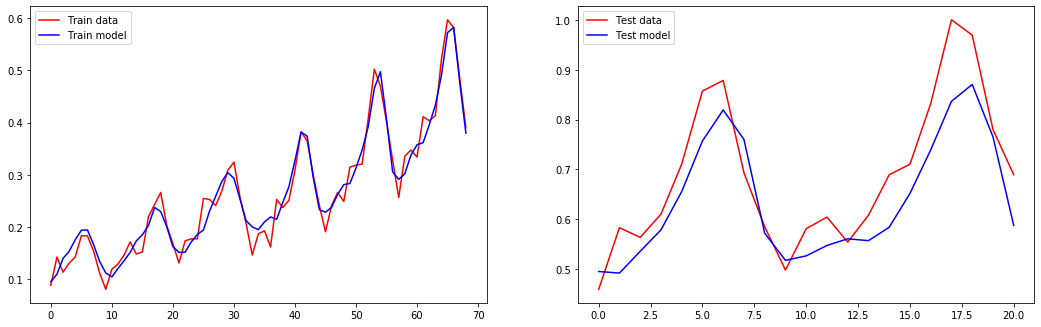

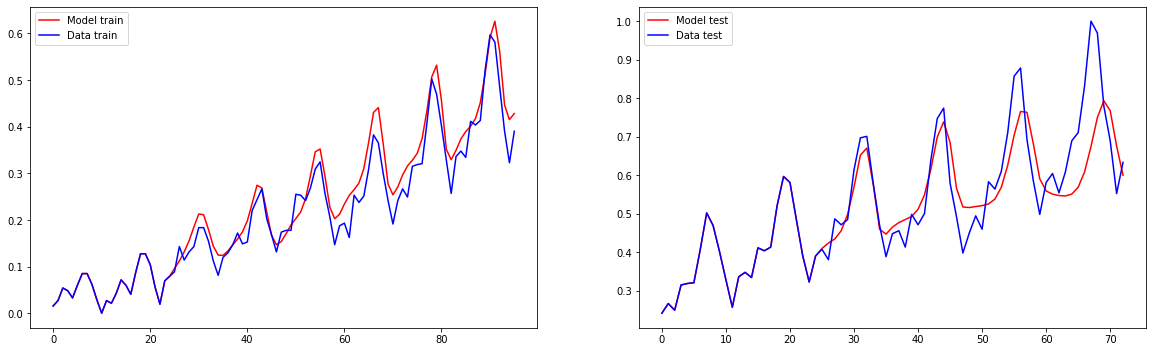

In [115]:
show_full_plots(model)
show_train_test_plots(*train_test_evaluate(model))

In [118]:
model = train_model(256, n_epochs=500, custom=True)

[100]	Train:	0.0015922882594168186	Train eval:	0.003998052639265855
	Test:	0.021194346249103546	Test eval:	0.06698339279383829

[200]	Train:	0.0016464218497276306	Train eval:	0.07417794565359752
	Test:	0.04434439539909363	Test eval:	0.16043312908851937

[300]	Train:	0.007547823246568441	Train eval:	0.4562109311421712
	Test:	0.11489222198724747	Test eval:	0.3691298341097897

[400]	Train:	0.006133097689598799	Train eval:	0.07388884325822194
	Test:	0.05432966724038124	Test eval:	0.14514478918624252

[500]	Train:	0.0008457160438410938	Train eval:	0.0015448822329441707
	Test:	0.023304620757699013	Test eval:	0.03633733318276601




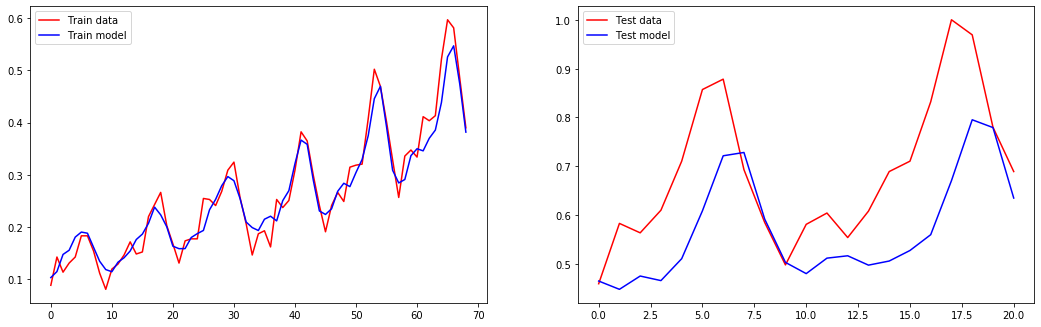

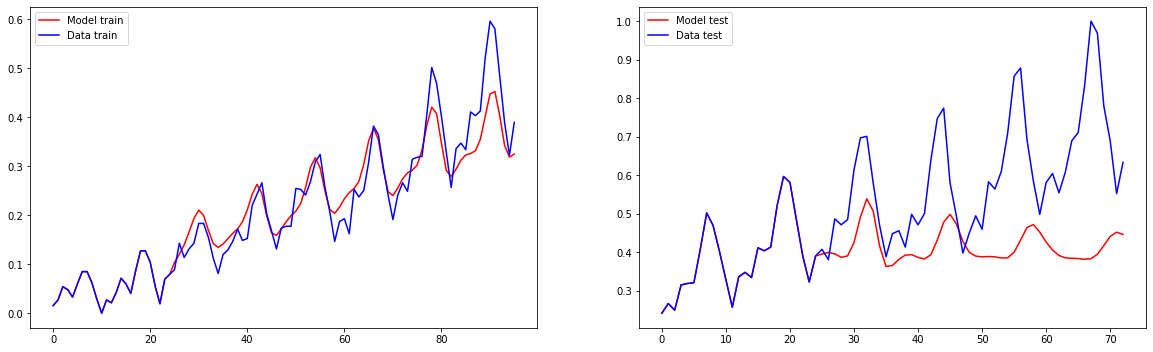

In [119]:
show_full_plots(model)
show_train_test_plots(*train_test_evaluate(model))

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: